# Gather summary statistics from network outputs
This example script displays the use of the nnadapter to
estimate normal distribution parameters from the output of each convolutional layer in a given pretrained model.

### 1. Setup
- Setup environment

In [1]:
import sys
import os
import numpy as np
import image
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

- Define backend

In [2]:
backend = 'caffe'  # currently supported: caffe, torch

- Load a caffe model

In [3]:
if backend == 'caffe':
    # make sure pycaffe is in your system path
    caffe_root = os.getenv("HOME") + '/caffe/'
    sys.path.insert(0, caffe_root + 'python')
    
    # Load CaffeAdapter class
    from caffeadapter import CaffeAdapter
    
    # Define the path to .caffemodel, deploy.prototxt and mean.npy
    #  Here we use the pretrained CaffeNet from the Caffe model zoo
    model_fp = caffe_root + 'models/bvlc_reference_caffenet/'
    weights_fp = model_fp + 'bvlc_reference_caffenet.caffemodel'
    prototxt_fp = model_fp + 'deploy.prototxt'
    
    mean_fp = caffe_root + 'data/ilsvrc12/ilsvrc_2012_mean.npy'
    # Alternatively, we could also define the mean as a numpy array:
    #  mean = np.array([104.00698793, 116.66876762, 122.67891434])
    
    adapter = CaffeAdapter(prototxt_fp, weights_fp, mean_fp)

- Load a torch model

In [4]:
if backend == 'torch':
    # Load TorchAdapter class
    from torchadapter import TorchAdapter
    
    # Define the path to the model .t7 file
    model_fp = 'models/resnet-18.t7'
    
    # Define mean and std
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Alternatively, we could also pass a .t7 file path to the constructor
    
    # Define the image input size to the model with order:
    #  Channels x Height x Width
    input_size = (3, 224, 224)
    
    # Define a list of required torch modules necessary to load the model
    modules = ['cunn', 'cudnn']
    # Homebrewn torch modules, that cannot be internally called via require(), 
    #  can still be loaded by passing a path to the lua script, e.g.:
    #   modules = ['mymodules/moduleX.lua']
    
    adapter = TorchAdapter(model_fp, modules, mean, std, input_size)

- Load available layers and their types

In [5]:
layer_types = adapter.get_layers()
for lname, ltype in layer_types.items():
    print('%s:\t%s' % (lname, ltype))

data:	Input
conv1:	Convolution
relu1:	ReLU
pool1:	Pooling
norm1:	LRN
conv2:	Convolution
relu2:	ReLU
pool2:	Pooling
norm2:	LRN
conv3:	Convolution
relu3:	ReLU
conv4:	Convolution
relu4:	ReLU
conv5:	Convolution
relu5:	ReLU
pool5:	Pooling
fc6:	InnerProduct
relu6:	ReLU
drop6:	Dropout
fc7:	InnerProduct
relu7:	ReLU
drop7:	Dropout
fc8:	InnerProduct
prob:	Softmax


- Select convolutional layers

In [6]:
conv_layers = []

if backend == 'caffe':
    conv_type = 'Convolution'
if backend == 'torch':
    conv_type = 'cudnn.SpatialConvolution'
    
conv_layers = [lname for lname, ltype in layer_types.items() if ltype == conv_type]

### 2. Forward images through network
- Define path to a directory containing images and run them through the network

In [7]:
images_dp = 'images/'

files = os.listdir(images_dp)
# Filter for jpeg extension
image_files = [os.path.join(images_dp, f) for f in files if f.endswith('.jpg')]

# Run in batched fashion
batch_size = 32

# As we run in batch mode, we have to store the intermediate layer outputs
layer_outputs = OrderedDict()
for layer in conv_layers:
    layer_outputs[layer] = []

for i in range(0, len(image_files), batch_size):
    batch = image_files[i:(i+batch_size)]
    
    # Forward batch through network
    #  The adapter takes care of loading images and transforming them to the right format.
    #  Alternatively, we could load and transform the images manually and pass a list of numpy arrays.
    adapter.forward(batch)
    
    # Save a copy of the outputs of the convolutional layers.
    for layer in conv_layers:
        output = adapter.get_layeroutput(layer).copy()
        layer_outputs[layer].append(output)

In [8]:
# Concatenate batch arrays to single outputs
for name, layer_output in layer_outputs.items():
    layer_outputs[name] = np.concatenate(layer_output, axis=0)

### 3. Calculate summary statistics
- Estimate mean and standard deviation per layer

In [9]:
means = [output.mean() for output in layer_outputs.values()]
stds  = [output.std() for output in layer_outputs.values()]

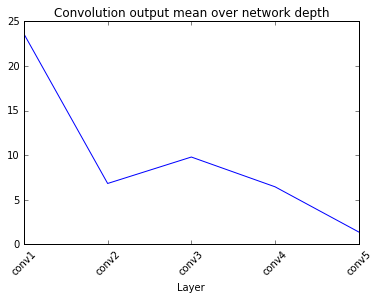

In [10]:
plt.plot(means)
plt.xticks(range(len(conv_layers)), conv_layers, rotation=45.0)
plt.title('Convolution output mean over network depth');
plt.xlabel('Layer');

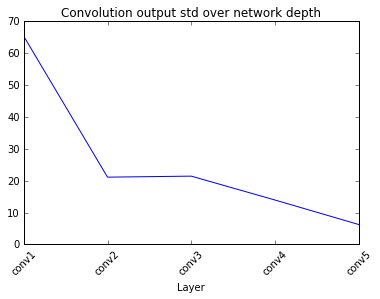

In [11]:
plt.plot(stds)
plt.xticks(range(len(conv_layers)), conv_layers, rotation=45.0)
plt.title('Convolution output std over network depth');
plt.xlabel('Layer');